In [2]:
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [3]:

path = datasets.download_data(MNIST_URL, ext='.gz'); path

PosixPath('/home/tako/.fastai/data/mnist.pkl.gz')

In [4]:
with gzip.open(path, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [7]:
x_train, y_train, x_valid, y_valid = map(tensor,(x_train, y_train, x_valid, y_valid ))
n,c = x_train.shape
print(n,c)

50000 784


/home/tako/devtools/test_env/env-ai-37/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


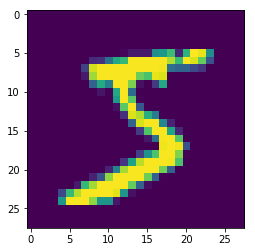

In [10]:
img = x_train[0]
plt.imshow(img.view(28,28))

In [12]:
w = torch.randn(784,10)
b = torch.randn(10)

In [23]:
def matmul(x,y):
    ar,ac = x.shape
    br,bc = y.shape
    assert ac==br
    c = torch.zeros(ar,bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                c[i,j] += x[i,k]*b[k,j]
                
    return c

In [18]:
a = x_valid[:50]
b = w

In [24]:
%time t1 = matmul(a,b)

CPU times: user 6.85 s, sys: 0 ns, total: 6.85 s
Wall time: 6.86 s


In [26]:
def matmul2(x,y):
    ar,ac = x.shape
    br,bc = y.shape
    assert ac==br
    c = torch.zeros(ar,bc)
    for i in range(ar):
        for j in range(bc):
            c[i,j] = sum((x[i,:]*b[:,j]))
                
    return c

In [37]:
%timeit -n 10 t1 = matmul2(a,b)

1.71 s ± 8.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [33]:
def matmul3(x,y):
    ar,ac = x.shape
    br,bc = y.shape
    assert ac==br
    c = torch.zeros(ar,bc)
    for i in range(ar):
        c[i] = (a[i].unsqueeze(-1) * b ).sum(dim=0)
#         for j in range(bc):
#             c[i,j] = sum((x[i,:]*b[:,j]))
                
    return c

In [36]:
%timeit -n 10 t1 = matmul3(a,b)

1.87 ms ± 248 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Broadcasting

[matrixmultiplication.xyz](matrixmultiplication.xyz)

When operating on two arrays/tensors, Numpy/PyTorch compares their shapes element-wise. It starts with the **trailing dimensions**, and works its way forward. Two dimensions are **compatible** when
    - they are equal, or,
    - one of them is 1, in which case that dimension is broadcasted to make it the same size

Arrays do not need to have the same number of dimensions. For example, if you have a `256*256*3` array of RGB values, and you want to scale each color in the image by a different value, you can multiply the image by a one-dimensional array with 3 values. Lining up the sizes of the trailing axes of these arrays according to the broadcast rules, shows that they are compatible:

       Image  (3d array): 256 x 256 x 3
       
       Scale  (1d array):             3
       
       Result (3d array): 256 x 256 x 3
       
       
The [numpy documentation](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html#general-broadcasting-rules) includes several examples of what dimensions can and can not be broadcast together.

## Einstein summation

In [38]:
def matmul4(a,b):
    return torch.einsum('ik,kj->ij',a,b)

In [39]:
%timeit -n 10 t1 = matmul4(a,b)

The slowest run took 21.13 times longer than the fastest. This could mean that an intermediate result is being cached.
384 µs ± 657 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [40]:
%timeit -n 10 a.matmul(b)

The slowest run took 5.77 times longer than the fastest. This could mean that an intermediate result is being cached.
115 µs ± 110 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## RELU

In [41]:
def normalize(x,m,s):
    return (x-m)/s

In [43]:
mean, std = x_train.mean(),x_train.std()
mean, std

(tensor(0.1304), tensor(0.3073))

In [44]:
x_train = normalize(x_train,mean,std)
x_valid = normalize(x_valid,mean,std)

In [45]:
mean, std = x_train.mean(),x_train.std()
mean, std

(tensor(-6.2598e-06), tensor(1.))

In [47]:
nh = 50

# kaiming init
w1 = torch.randn(m,nh)/math.sqrt(2/m)
b1 = torch.randn(nh)
w2 = torch.randn(nh,1)/math.sqrt(2/m)
b2 = torch.rand(1)


In [51]:
def relu(x):
    return x.clamp_min(0.)-.5

if use normal relu without -.5 your mean will be .5 and not 0. seems legit

In [52]:
def lin(x,w,b):
    return x@w+b

In [53]:
relu(lin(x_valid,w,b))

RuntimeError: The size of tensor a (10000) must match the size of tensor b (784) at non-singleton dimension 0

In [59]:
w1 = torch.zeros(m,nh)
torch.nn.modules.conv._ConvNd.reset_parameters??

Signature: torch.nn.modules.conv._ConvNd.reset_parameters(self)
Docstring: <no docstring>
Source:   
    def reset_parameters(self):
        n = self.in_channels
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)
File:      ~/devtools/test_env/env-ai-37/lib/python3.7/site-packages/torch/nn/modules/conv.py
Type:      function


what is the 5 ???


Read section 2.2 in [Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification](https://arxiv.org/abs/1502.01852)